# BBC - Laboratoire 2
## Alignement de séquences et arbres phylogénétiques

- Professeur: Carlos Peña (<a href="mailto:carlos.pena@heig-vd.ch">carlos.pena@heig-vd.ch</a>)
- Assistant: Xavier Brochet (<a href="mailto:xavier.brochet@heig-vd.ch">xavier.brochet@heig-vd.ch</a>)

Date: Printemps 2019

> ## Objectifs pédagogiques
Pour réaliser ce laboratoire, du vocabulaire et des notions de base en biologie seront introduits ou perfectionnés (revoir Labo-1 si nécessaire). A la fin du laboratoire, l’étudiant devrait:
- Etre à l’aise avec l’utilisation d’Entrez Direct pour accéder à Genbank.
- Savoir utiliser des outils d’alignement de séquence, à l’aide du logiciel Aliview et avec la librairie biopython.
- Savoir construire un arbre phylogénétique à partir d’un alignement et l’interpréter.


> ## But du labo
La septicémie hémorragique virale est une maladie très contagieuse et mortelle qui touche les poissons de type salmonidés (les humains ne sont pas touchés). Elle est causée par un virus qui engendre chaque année de grosses pertes économiques pour les pisciculteurs. Votre but est de visualiser comment le virus se propage dans le monde, en comparant les séquences de la protéine G (glycoprotéine se trouvant à la surface du virus) de plusieurs isolats.

> ## Démarche
1. Visualisation de la présence du virus dans le monde (Genbank, Entrez Direct et biopython).
2. Alignement des séquences protéiques pour pouvoir les comparer (MUSCLE, (ClustalW), Clustal Omega).
3. Construction de l’arbre phylogénétique et clustering hiérarchique pour identifier des groupes d’isolats similaires.


> ## Rapport de labo

> <p >Merci de répondre aux questions posées sur fond cyan de façon concise dans la cellule située <u>juste en dessous</u>, et de nous retourner ce notebook.
> <p style="background-color:#AFEEEE;padding:3px"><font size="4"><b>0. </b></font> Ceci est une question.</p>

## 1. Le virus dans le monde - visualisation d’isolats séquencés

Comme lors du premier labo, vous allez apprendre à utiliser certains outils à la fois en mode graphique et en mode ligne de commande.

Votre premier objectif est de récupérer sur Genbank la localisation géographique de toutes les souches séquencées du virus (protéine G uniquement) et de les visualiser sur une carte du monde.

<b>→ Depuis votre navigateur, allez sur le site de [Genbank](http://www.ncbi.nlm.nih.gov/genbank/) et dans la barre de recherche, tapez</b>: G[gene] AND VHSV[orgn] NOT "mRNA"[title] AND "complete cds"[title]

Cette requête limite les recherches aux entrées dont le nom du gène s’intitule G, dont l’organisme est le VHSV (Viral Hemorrhagic Septicemia Virus), dont le titre ne contient pas le mot “mRNA” et dont la séquence est complète.

<b>→ Cliquez sur la première entrée: https://www.ncbi.nlm.nih.gov/nuccore/MH836523.1</b>

Dans la partie FEATURES - source, vous pouvez voir que le pays d’origine est Islande.

<b>→ Cliquez sur cette entrée: [http://www.ncbi.nlm.nih.gov/nuccore/341904092](http://www.ncbi.nlm.nih.gov/nuccore/341904092) </b>
Vous pouvez voir qu’en plus du pays, la latitude et la longitude sont également indiqués.

<p style="background-color:#AFEEEE;padding:3px"><font size="4"><b>1.1 </b></font>Quelles sont les coordonnées (latitude, longitude) et pays d’origine de l’isolat dont l'ACCESSION=HQ112247 et gi=341904064 (attention le gi n'est officiellement plus utilisé)?</p>

Originaire de Finlande aux latitudes et longitudes : 60.24 N 22.06 E

Votre recherche avec la requête initiale a retourné 390 entrées. Afin de récupérer les données géographiques de tous les isolats, il vous faut avoir recours à un langage de script. Comme vu au Labo-1, nous ferons appel à Entrez Direct en utilisant la librairie biopython.

<b>→ Importez les modules suivants</b>

In [1]:
from Bio import Entrez
Entrez.email = "vincent.guidoux@heig-vd.ch" # une adresse email valide est nécessaire
from mpl_toolkits.basemap import Basemap # pour dessiner une carte du monde
import matplotlib.pyplot as plt # pour générer des graphiques
%matplotlib inline
#problème avec le module mpl_toolkits.basemap..
#esssai pour le récupérer
#j'ai mis a jour: 
#pip3.6 install --upgrade biopython --> pas fonctionné
#pip3 install --upgrade jupyter matplotlib numpy pandas scipy scikit-learn six Collecting jupyter
#pip3.6 install notebook --upgrade 
#conda install -c anaconda biopython


<b>→ Commencez par récupérer les identifiants gi correspondant à la requête en utilisant Entrez.esearch()</b>

In [2]:
query = 'G[gene] AND VHSV[orgn] NOT "mRNA"[title] AND "complete cds"[title]'
handle = Entrez.esearch(db='nucleotide',retmax=1000,term=query)
record = Entrez.read(handle)
gi = record['IdList']
#print(gi)
print(len(gi))

390


<b>→ Allez chercher les informations Genbank sur ces séquences en utilisant Entrez.efetch()</b>

In [3]:
protein_info = Entrez.efetch(db="nucleotide",id=gi,rettype="gb",retmode="xml")
protein_info = Entrez.read(protein_info)
print(len(protein_info))

390


<font face='courier'>protein_info</font> est une liste de 390 éléments. Chaque élément consiste en une structure de listes et dictionnaires contenant toute l’information de Genbank correpondant à la requête.

<b>→ Imprimez le dixième élément de protein_info et quelques unes de ses caractéristiques.</b>


In [6]:
print(protein_info[10])
print('')
print('')
print(protein_info[10].keys())
print('')
print('')
features = protein_info[10]['GBSeq_feature-table'][0]['GBFeature_quals']
# features = protein_info[60]['GBSeq_feature-table'][0]['GBFeature_quals']
print(features)

DictElement({'GBSeq_locus': 'KU728260', 'GBSeq_length': '1524', 'GBSeq_strandedness': 'single', 'GBSeq_moltype': 'cRNA', 'GBSeq_topology': 'linear', 'GBSeq_division': 'VRL', 'GBSeq_update-date': '01-MAR-2017', 'GBSeq_create-date': '01-MAR-2017', 'GBSeq_definition': 'Viral hemorrhagic septicemia virus isolate DK-7690 glycoprotein (G) gene, complete cds', 'GBSeq_primary-accession': 'KU728260', 'GBSeq_accession-version': 'KU728260.1', 'GBSeq_other-seqids': ['gb|KU728260.1|', 'gi|1149552504'], 'GBSeq_source': 'Viral hemorrhagic septicemia virus', 'GBSeq_organism': 'Viral hemorrhagic septicemia virus', 'GBSeq_taxonomy': 'Viruses; ssRNA viruses; ssRNA negative-strand viruses; Mononegavirales; Rhabdoviridae; Novirhabdovirus', 'GBSeq_references': [DictElement({'GBReference_reference': '1', 'GBReference_position': '1..1524', 'GBReference_authors': ['Mikkelsen,S.S.', 'Panzarin,V.', 'Schuetze,H.', 'Skall,H.F.', 'Fusaro,A.', 'Korsholm,H.', 'Olesen,N.-J.'], 'GBReference_title': 'Molecular tracing o

<p style="background-color:#AFEEEE;padding:3px"><font size="4"><b>1.2 </b></font> Quel est le pays d’origine du 60ème isolat dans notre liste?
</p>

Danemark, pour arriver à ce résultat, j'ai exécuté la ligne `features = protein_info[60]['GBSeq_feature-table'][0]['GBFeature_quals']`, et chercher l'occurence de `country`

<b>→ Pour extraire le pays automatiquement, faites une boucle sur les features jusqu’à tomber sur “country”:</b>

In [9]:
for j,feat in enumerate(features):
    if feat['GBQualifier_name']=='country':
        print("Pays d'origine: "+feat['GBQualifier_value'].split(':')[0])

Pays d'origine: Denmark


<p style="background-color:#AFEEEE;padding:3px"><font size="4"><b>1.3 </b></font> Généralisez ce code pour qu’il imprime le pays d’origine des 390 isolats et enregistre le résultat dans une variable (liste de 390 éléments) appelée <font face='courier'>country</font> (si le pays n’est pas disponible, ajoutez le texte ‘NA’ (not available) à la place).
</p>

In [15]:
country = []
                                           
for info in protein_info: 
    current_country = 'NA'
    for j,feat in enumerate(info['GBSeq_feature-table'][0]['GBFeature_quals']):

        if feat['GBQualifier_name']=='country':
            current_country = feat['GBQualifier_value'].split(':')[0]
    country.append(current_country)
    
print(country)                              

['Iceland', 'Iceland', 'Finland', 'Finland', 'Finland', 'Finland', 'Finland', 'Finland', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Denmark', 'Italy', 'Italy', 'Italy', 'Italy', 'Italy', 'Italy', 'Italy', 'Italy', 'It

<b>→ Pour certains isolats, la latitude et la longitude sont également indiqués. Par exemple, exécutez:</b>


In [16]:
print(protein_info[294]['GBSeq_feature-table'][0]['GBFeature_quals'])

[DictElement({'GBQualifier_name': 'organism', 'GBQualifier_value': 'Viral hemorrhagic septicemia virus'}, attributes={}), DictElement({'GBQualifier_name': 'mol_type', 'GBQualifier_value': 'viral cRNA'}, attributes={}), DictElement({'GBQualifier_name': 'isolate', 'GBQualifier_value': 'ka664_04'}, attributes={}), DictElement({'GBQualifier_name': 'db_xref', 'GBQualifier_value': 'taxon:11287'}, attributes={}), DictElement({'GBQualifier_name': 'country', 'GBQualifier_value': 'Finland: Archipelago Sea'}, attributes={}), DictElement({'GBQualifier_name': 'lat_lon', 'GBQualifier_value': '60.29 N 21.29 E'}, attributes={}), DictElement({'GBQualifier_name': 'collection_date', 'GBQualifier_value': '09-Jun-2004'}, attributes={}), DictElement({'GBQualifier_name': 'identified_by', 'GBQualifier_value': 'T. Gadd'}, attributes={}), DictElement({'GBQualifier_name': 'PCR_primers', 'GBQualifier_value': 'fwd_name: G1_forward, fwd_seq: cgggcaggcgaaggacta, fwd_name: G2_forward, fwd_seq: atggaatggaatacttttttc, 

Dans ce cas, <font face='courier'>lat_lon = 60.29 N 21.29 E</font> (latitude 60.29°, longitude 21.29°).

<p style="background-color:#AFEEEE;padding:3px"><font size="4"><b>1.4 </b></font>  Généralisez votre code pour qu’il enregistre aussi la latitude et la longitude dans deux variables séparées (mettez un <font face='courier'>float(‘nan’)</font> si elles ne sont pas disponibles). Astuce: Utilisez la fonction split(‘ ‘) pour extraire les nombres qui vous intéressent de lat_lon (à convertir en float aussi). 
</p>

In [21]:
lat_lon = []

for info in protein_info: 
    current_lat_lon = {'lat': float('nan'), 'lon': float('nan')}
    for j,feat in enumerate(info['GBSeq_feature-table'][0]['GBFeature_quals']):
        
        if feat['GBQualifier_name']=='lat_lon':
            current = feat['GBQualifier_value'].split('N')
            lat = current[0]
            lon = current[1].split('E')[0]
            current_lat_lon['lat'] = lat
            current_lat_lon['lon'] = lon
    lat_lon.append(current_lat_lon)
    
print(len(lat_lon))

390


Comme vous le verrez, la latitude et la longitude ne sont disponibles que pour un petit nombre d’isolats, alors que le pays d’origine est connu pour la majorité d’entre eux. Afin de pouvoir représenter les isolats sur une carte du monde, nous allons utiliser une valeur moyenne de latitude et de longitude par pays pour les isolats dont on ne connaît que le pays d’origine.

<b>→ Utilisez la librairie pandas pour lire le fichier countries_latlon.csv.</b>
> En cas de soucis d'encodage, ajoutez les lignes suivantes à ~./bash_profile et re-lancez ipython notebook:
> <p>export LC_ALL=en_US.UTF-8</p>
> export LANG=en_US.UTF-8

In [22]:
import pandas as pd # très utile pour lire des fichiers du type csv, tsv, etc.
country_latlon = pd.read_csv('countries_latlon.csv',sep='\t',header=0)
print(country_latlon)

    iso-code   latitude   longitude                           country
0         AD  42.546245    1.601554                           Andorra
1         AE  23.424076   53.847818              United Arab Emirates
2         AF  33.939110   67.709953                       Afghanistan
3         AG  17.060816  -61.796428               Antigua and Barbuda
4         AI  18.220554  -63.068615                          Anguilla
5         AL  41.153332   20.168331                           Albania
6         AM  40.069099   45.038189                           Armenia
7         AN  12.226079  -69.060087              Netherlands Antilles
8         AO -11.202692   17.873887                            Angola
9         AQ -75.250973   -0.071389                        Antarctica
10        AR -38.416097  -63.616672                         Argentina
11        AS -14.270972 -170.132217                    American Samoa
12        AT  47.516231   14.550072                           Austria
13        AU -25.274

<b>→ Pour trouver la latitude et la longitude moyenne de l’Iran par exemple, exécutez le code suivant:</b>

In [23]:
idx_country = list(country_latlon['country']).index('Iran')
lat = country_latlon['latitude'][idx_country]
lon = country_latlon['longitude'][idx_country]
print('Latitude: '+str(lat))
print('Longitude: '+str(lon))

Latitude: 32.427908
Longitude: 53.68804599999999


<p style="background-color:#AFEEEE;padding:3px"><font size="4"><b>1.5 (a) </b></font> Généralisez votre code pour qu’il enregistre la latitude et la longitude moyenne lorsque celles-ci ne sont pas disponibles mais que vous connaissez le pays d’origine.</p>

<p style="background-color:#AFEEEE;padding:3px"><font size="4"><b>1.5 (b) </b></font>Afin de retrouver facilement les isolats par leur accession.version (en plus du gi), définissez aussi <font face='courier'>name=[]</font> et rajoutez dans votre boucle </b><font face='courier'>name.append(protein_info[i]['GBSeq_accession-version'])</font>
</p>

In [44]:
index = 0
name = []

for i in range(len(lat_lon)):
    current_lat_lon = {'lat': float('nan'), 'lon': float('nan')}
    if lat_lon[i]['lat'] != None:
        current_country = country[i]
        if current_country != 'NA':
            index = index + 1
            idx_country = list(country_latlon['country']).index(country[i])
            current_lat_lon['lat'] = country_latlon['latitude'][idx_country]
            current_lat_lon['lon'] = country_latlon['longitude'][idx_country]
            lat_lon[i] = current_lat_lon
            name.append(protein_info[i]['GBSeq_accession-version'])

print(index)
print(' ')
print('-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-')
print(' ')
print(lat_lon)
print(' ')
print('-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-')
print(' ')
print(name)

302
 
-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-
 
[{'lat': 64.96305100000001, 'lon': -19.020835}, {'lat': 64.96305100000001, 'lon': -19.020835}, {'lat': 61.92411, 'lon': 25.748151}, {'lat': 61.92411, 'lon': 25.748151}, {'lat': 61.92411, 'lon': 25.748151}, {'lat': 61.92411, 'lon': 25.748151}, {'lat': 61.92411, 'lon': 25.748151}, {'lat': 61.92411, 'lon': 25.748151}, {'lat': 56.26392, 'lon': 9.501785}, {'lat': 56.26392, 'lon': 9.501785}, {'lat': 56.26392, 'lon': 9.501785}, {'lat': 56.26392, 'lon': 9.501785}, {'lat': 56.26392, 'lon': 9.501785}, {'lat': 56.26392, 'lon': 9.501785}, {'lat': 56.26392, 'lon': 9.501785}, {'lat': 56.26392, 'lon': 9.501785}, {'lat': 56.26392, 'lon': 9.501785}, {'lat': 56.26392, 'lon': 9.501785}, {'lat': 56.26392, 'lon': 9.501785}, {'lat': 56.26392, 'lon': 9.501785}, {'lat': 56.26392, 'lon': 9.501785}, {'lat': 56.26392, 'lon': 9.501785}, {'lat': 56.26392, 'lon': 9.501785}, {'lat': 56.26392, 'lon': 9.501785}, {'lat': 56.26392, 'lon': 9.5017

<b>→ Connaissant la latitude et la longitude de la majorité des isolats, représentez-les graphiquement sur une carte du monde:</b>


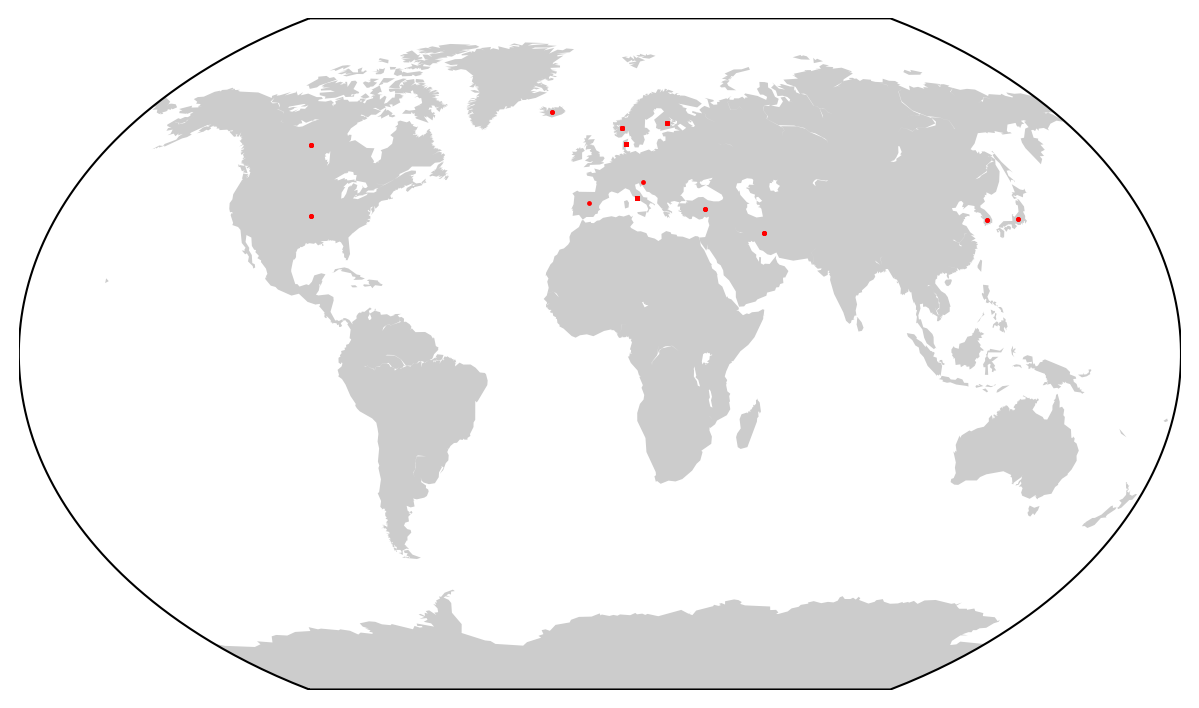

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# print(len(lat))

fig = plt.figure(num=None,figsize=(10,7),dpi=150) # ouvre une fenêtre
m = Basemap(projection='kav7',lon_0=0,lat_0=60) # carte du monde avec projection
for current_lat_lon in lat_lon: # On parcourt chaqunes des latitudes et longitudes enregistrée
    x, y = m(current_lat_lon['lon'],current_lat_lon['lat']) # transforme lat,lon avec la projection utilisée
    m.scatter(x,y,7,marker='.',color='r') # représente les isolats en rouge
m.fillcontinents(zorder=0) # dessine les continents
plt.show()     
fig.savefig('map_isolats.png', dpi=fig.dpi) # sauve la figure

<p style="background-color:#AFEEEE;padding:3px"><font size="4"><b>1.6 </b></font>A votre avis, s’agit-il d’un virus qui se reproduit dans les eaux chaudes ou plutôt dans les eaux froides?</p>

Plutôt dans les eaux froides




## 2. Alignement des séquences protéiques pour pouvoir les comparer
Afin de comprendre comment le virus s’est propagé dans le monde, nous allons comparer les séquences protéiques des différents isolats. Ceci nous permettra de regrouper les isolats “les plus similaires” et nous ferons l’hypothèse vraisemblable qu’il ont une origine commune du fait de leur similarité.

Pour comparer les séquences protéiques et voir à quel point elles diffèrent, il est nécessaire de commencer par les aligner. Vous allez apprendre à utiliser l’outil graphique Aliview pour aligner les séquences et les inspecter visuellement. Vous verrez par la suite comment réaliser ces mêmes opérations directement en python avec la librairie biopython, ce qui vous permettra d’automatiser le processus.

<b>→ Utilisez la liste de gi pour pouvoir générer un fichier fasta contenant toutes les séquences protéiques qui nous intéressent (pour rappel, notre requête initiale était: <font face='courier'>'G[gene] AND VHSV[orgn] NOT "mRNA"[title]"</font></b>


In [46]:
from Bio import SeqIO
print(len(gi))
#print(len(giWCountry))
protein_seq = Entrez.efetch(db="nucleotide",id=gi,rettype="fasta_cds_aa",retmode="text")
#protein_seq = Entrez.efetch(db="nucleotide",id=giWCountry,rettype="fasta_cds_aa",retmode="text")
protein_seq = list(SeqIO.parse(protein_seq, "fasta"))
print(len(protein_seq))

390
410


<b>→ Imprimez l’élément 0 et l’élément 212 de <font face='courier'>protein_seq</font></b>

In [50]:
#pas dans le labo juste pour moi
""" 
for i in range(len(protein_seq)):
    print('--> '+str(i))
    print(protein_seq[i])
    print('')
    #pas besoin de cette cellule dans le questionnaire des étudiants 194
"""

" \nfor i in range(len(protein_seq)):\n    print('--> '+str(i))\n    print(protein_seq[i])\n    print('')\n    #pas besoin de cette cellule dans le questionnaire des étudiants 194\n"

In [48]:
print(protein_seq[0])
print('')
#print(protein_seq[192])
#print('')
#print(protein_seq[193])
#print('')
print(protein_seq[212])
print('')
#print(protein_seq[195])
#print('')
print(len(protein_seq))

ID: lcl|MH836523.1_prot_AZH81386.1_1
Name: lcl|MH836523.1_prot_AZH81386.1_1
Description: lcl|MH836523.1_prot_AZH81386.1_1 [gene=G] [protein=glycoprotein] [protein_id=AZH81386.1] [location=1..1524] [gbkey=CDS]
Number of features: 0
Seq('MEWNTFFLVILIIIIKSTTSQITQRPPVENISTYHADWDTPLYTHPSNCRKNSF...QMV', SingleLetterAlphabet())

ID: lcl|KM244768.1_prot_AKC42401.1_3
Name: lcl|KM244768.1_prot_AKC42401.1_3
Description: lcl|KM244768.1_prot_AKC42401.1_3 [gene=M] [protein=matrix protein] [protein_id=AKC42401.1] [location=2217..2822] [gbkey=CDS]
Number of features: 0
Seq('MTLFKRKRTILVPPPHITSNDEDRVSTILTEGTLTITGPPPGNQVDKICMAMKL...QPR', SingleLetterAlphabet())

410


<p style="background-color:#AFEEEE;padding:3px"><font size="4"><b>2.1 </b></font>Que constatez-vous concernant le nom du gène de <font face='courier'>protein_seq[212]</font> et le nombre d'entrées retournées? Pourquoi ce gène apparaît-il dans notre liste si la requête initiale exigeait “G[gene]” (astuce: allez voir sur le site de Genbank l'entrée correspondant à l’identifiant KM244768).</p>

Le nom du gène est M et non **G** comme demandé dans la requête. Dans une de ses features, le gene **G** apparait: 
```
gene    2911..4434
        /gene="G"```
[source](https://www.ncbi.nlm.nih.gov/nuccore/KM244768)

Avant de continuer, nous devons donc nous assurer que seules les séquences protéiques correspondant au gène G sont gardées.

<b>→ Faites une boucle pour tester le nom du gène</b>


In [49]:
print(len(protein_seq))
updated_protein_seq = [ ps for i,ps in enumerate(protein_seq) if ps.description.find('gene=G')>0 ]
print(len(updated_protein_seq))

# verify visually that only G genes are left
desc = [ps.description for i,ps in enumerate(updated_protein_seq)]
desc

410
390


['lcl|MH836523.1_prot_AZH81386.1_1 [gene=G] [protein=glycoprotein] [protein_id=AZH81386.1] [location=1..1524] [gbkey=CDS]',
 'lcl|MH836522.1_prot_AZH81385.1_1 [gene=G] [protein=glycoprotein] [protein_id=AZH81385.1] [location=1..1524] [gbkey=CDS]',
 'lcl|MF176930.1_prot_ATO91455.1_1 [gene=G] [protein=glycoprotein] [protein_id=ATO91455.1] [location=1..1524] [gbkey=CDS]',
 'lcl|MF176929.1_prot_ATO91454.1_1 [gene=G] [protein=glycoprotein] [protein_id=ATO91454.1] [location=1..1524] [gbkey=CDS]',
 'lcl|MF176928.1_prot_ATO91453.1_1 [gene=G] [protein=glycoprotein] [protein_id=ATO91453.1] [location=1..1524] [gbkey=CDS]',
 'lcl|MF176927.1_prot_ATO92013.1_1 [gene=G] [protein=glycoprotein] [protein_id=ATO92013.1] [location=1..1524] [gbkey=CDS]',
 'lcl|MF176926.1_prot_ATO92012.1_1 [gene=G] [protein=glycoprotein] [protein_id=ATO92012.1] [location=1..1524] [gbkey=CDS]',
 'lcl|MF176925.1_prot_ATO92011.1_1 [gene=G] [protein=glycoprotein] [protein_id=ATO92011.1] [location=1..1524] [gbkey=CDS]',
 'lcl|KU

<b>→ Maintenant que vous avez les séquences du gène G uniquement, remplacez l'id par le numéro d'accès et le nom du pays source (ceci facilitera les analyses par la suite).</b>

In [51]:
print(len(updated_protein_seq))
for i,ps in enumerate(updated_protein_seq):
    access_number = ps.name.split('|')[1].split('_')[0]
    #print(ps) del liste[1]
    #if(country[i]):
    print(str(i)+" "+country[i])
    country_tmp = country[i].replace(' ','-')
    #print(country_tmp)
    updated_protein_seq[i].description = ''
    updated_protein_seq[i].id = access_number+'_'+country_tmp

390
0 Iceland
1 Iceland
2 Finland
3 Finland
4 Finland
5 Finland
6 Finland
7 Finland
8 Denmark
9 Denmark
10 Denmark
11 Denmark
12 Denmark
13 Denmark
14 Denmark
15 Denmark
16 Denmark
17 Denmark
18 Denmark
19 Denmark
20 Denmark
21 Denmark
22 Denmark
23 Denmark
24 Denmark
25 Denmark
26 Denmark
27 Denmark
28 Denmark
29 Denmark
30 Denmark
31 Denmark
32 Denmark
33 Denmark
34 Denmark
35 Denmark
36 Denmark
37 Denmark
38 Denmark
39 Denmark
40 Denmark
41 Denmark
42 Denmark
43 Denmark
44 Denmark
45 Denmark
46 Denmark
47 Denmark
48 Denmark
49 Denmark
50 Denmark
51 Denmark
52 Denmark
53 Denmark
54 Denmark
55 Denmark
56 Denmark
57 Denmark
58 Denmark
59 Denmark
60 Denmark
61 Denmark
62 Denmark
63 Denmark
64 Denmark
65 Denmark
66 Denmark
67 Denmark
68 Denmark
69 Denmark
70 Denmark
71 Denmark
72 Denmark
73 Denmark
74 Denmark
75 Denmark
76 Denmark
77 Denmark
78 Denmark
79 Denmark
80 Denmark
81 Denmark
82 Denmark
83 Denmark
84 Italy
85 Italy
86 Italy
87 Italy
88 Italy
89 Italy
90 Italy
91 Italy
92 Italy
9

<b>→ Créez un fichier FASTA avec ces séquences et ouvrez-le avec un éditeur de texte pour voir ce qu'il contient.</b>

In [52]:
output_handle = open('labo-2_protein-sequences.fasta', 'w')
SeqIO.write(updated_protein_seq, output_handle, "fasta")
output_handle.close()

Instalation de Aliview: https://ormbunkar.se/aliview/

<b>→ Sur votre ordinateur, lancez le programme Aliview et utilisez File > Open File pour ouvrir le fichier que vous venez de créer.</b>

<b>→ Sur Aliview, allez sur Align > Realign everything et cliquez sur Ok.</b>

Par défaut, Aliview utilise l’algorithme MUSCLE pour aligner les séquences. 

<b>→ Sur Aliview, inspectez l’alignement visuellement et assurez-vous que tout semble normal.</b>

<p style="background-color:#AFEEEE;padding:3px"><font size="4"><b>2.2 </b></font>Pourquoi est-ce que l'une des séquences est plus courte que les autres? Astuce: allez sur Genbank depuis votre navigateur pour voir l'entrée correspondant à la séquence très courte.</p>


Ce n'est pas la séquence complète

Viral hemorrhagic septicemia virus isolate KV010308-4 nucleoprotein (N), phosphoprotein (P), and matrix protein (M) genes, complete cds; and glycoprotein (G) gene, **partial cds**.

[FJ362514.1](https://www.ncbi.nlm.nih.gov/nuccore/FJ362514.1)

[What is the mean of Cds, when it say in a sequence "partial Cds"?](https://www.researchgate.net/post/What_is_the_mean_of_Cds_when_it_say_in_a_sequence_partial_Cds)

Sur Aliview, il est possible d’enregistrer l’alignement: File > Save as Clustal (aln). 

Pour la suite du labo, nous allons générer ce même alignement à l’aide de la librairie biopython et faire quelques analyses sur cet alignement.

<b>→ Importez les modules suivants:</b>

In [53]:
from Bio.Align.Applications import MuscleCommandline
from Bio import AlignIO

<b>→ Spécifiez le chemin vers votre exécutable muscle</b>
#faute que j'installe muscle sur mon ordi...
https://drive5.com/muscle/downloads.htm

In [58]:
#muscle_loc = r'/usr/bin/muscle' # modifier si nécessaire
#muscle_loc = r'/Users/xavierbrochet/Documents/programmes/muscle3.8.31_i86darwin64'
muscle_loc = r'muscle3.8.31_i86win32'

<b>→ Réalisez l’alignement à partir du fichier FASTA contenant les séquences</b>

In [60]:
in_file = 'labo-2_protein-sequences.fasta'
out_file = 'labo-2_protein-sequences.aln'

muscle_cline = MuscleCommandline(cmd=muscle_loc,input=in_file,out=out_file,clwstrict=True)
#print(muscle_cline)
stdout, stderr = muscle_cline()

muscle_align = AlignIO.read(out_file,'clustal') # this command actually performs the alignment
print(muscle_align)

SingleLetterAlphabet() alignment with 390 rows and 507 columns
MEWNTFFLVILIIIIKSTTSQITQRPPAENISTYHADWDTPLYT...QMI HQ112236.1_Finland
MEWNTFFLVILIIIIKSTTSQITQRPPAENISTYHADWDTPLYT...QMI HQ112233.1_Finland
MEWNTFFLVILIIIIKSTTSQITQRPPAENISTYHADWDTPLYT...QMI AY546577.1_NA
MEWNTFFLVILIIIIKSTTSQITQRPPAENISTYHADWDTPLYT...QMI KM244767.1_NA
MEWNTFFLVILIIIIKSTTSQITQRPPAENISTYHADWDTPLYT...QMI AY546578.1_NA
MEWNTFFLVILIIIIKSTTSQITQRPPAENISTYHADWDTPLYT...QMI AY546576.1_NA
MEWNTFFLVILIIIIKSTTSQITQRPPAENISTYHADWDTPLYT...QMI HQ112246.1_Finland
MEWNTFFLVILIIIIKSTTSQITQRPPAENISTYHADWDTPLYT...QMI HQ112243.1_Finland
MEWNTFFLVILIIIIKSTTSQIIQRPPAENISTYHADWDTPLYT...QMI HQ112245.1_Finland
MEWNTFFLVILIIIIKSTTSQIIQRPPAENISTYHADWDTPLYT...QMI HQ112244.1_Finland
MEWNTFFLVILIIIIKSTTSQIIQRPPAENISTYHADWDTPLYT...QMI HQ112239.1_Finland
MEWNTFFLVILIIIIKSTTSQIIQRPPAENISTYHADWDTPLYT...QMI HQ112238.1_Finland
MEWNTFFLVILIIIIKSTTSQIIQRPPAENISTYHADWDTPLYT...QMI HQ112237.1_Finland
MEWNTFFLVILIIIIKSTTSQIIQRPPAENISTYHADWDTPLYT...

![AliView](./AliView_2_2.JPG)

Le fichier .aln généré peut être ouvert dans Aliview pour l’inspecter visuellement.

## 3. Construction de l’arbre phylogénétique et clustering hiérarchique pour identifier des groupes similaires
A partir de cet alignement, il est possible de générer un arbre phylogénétique. Par souci de temps, nous utiliserons FastTree qui est très rapide, même si cet outil n’est pas le mieux adapté pour construire un arbre phylogénétique à partir de séquences très proches comme c’est le cas ici.

<b>→ Générez l’arbre avec FastTree</b>
INSTALLTION: http://microbesonline.org/fasttree/#Install


In [61]:
from Bio.Phylo.Applications import FastTreeCommandline

# convert aln to phy format
out_phy = 'labo-2_protein-sequences.phy'
AlignIO.convert(out_file,'clustal',out_phy, 'phylip-relaxed')

# generate the phylogenetic tree with FastTree
out_tree = 'labo-2_protein-sequences.tre'
#cmd_fasttree = r'/home/aitana/Applications/FastTree' 
#cmd_fasttree = r'/Users/xavierbrochet/Documents/programmes/FastTree' # modifier si nécessaire
cmd_fasttree = r'FastTree' # modifier si nécessaire

fasttree_cmdline = FastTreeCommandline(cmd=cmd_fasttree,fastest=True,input=out_phy,out=out_tree)
print(fasttree_cmdline)
out_log, err_log = fasttree_cmdline()

# load tree
from Bio import Phylo
tree = Phylo.read('labo-2_protein-sequences.tre', 'newick')
#print(tree)
#Phylo.draw(tree)

FastTree -fastest -out labo-2_protein-sequences.tre labo-2_protein-sequences.phy


<b>→ Ouvrez le fichier <font face='courier'>labo-2_protein-sequences.tre</font> dans TreeViewX et choisissez le mode de visualisation “phylogram” (bouton en haut à droite) et zoomez pour voir les groupes.</b>

Utilisation de http://ab.inf.uni-tuebingen.de/data/software/dendroscope3/download/welcome.html
ou de iToL en ligne... https://itol.embl.de/

<p style="background-color:#AFEEEE;padding:3px"><font size="4"><b>3.1 </b></font>De quels pays vient l'isolat le plus proches des isolats de Corée du Sud?</p>

Du japon

![nearest](./tree.JPG)

Combien de groupes voyez-vous? 
Ca dépend! Le nombre de groupes dépend du seuil utilisé pour admettre, ou non, que deux isolats font partie du même groupe. 

Afin de mieux visualiser la propagation du virus dans le monde, nous allons regrouper les séquences (i.e. les isolats) en 4 groupes et voir leur localisation géographique sur une carte du monde. Pour obtenir ces 4 groupes, nous allons commencer par calculer les distances (phylogénétiques) entre les isolats et réaliser un clustering hiérarchique à partir duquel nous obtiendrons 4 groupes.

<b>→ Calculez les distances entre les isolats</b> (ceci peut prendre un petit moment...)


In [ ]:
dmat = []
leaves = [str(cladit) for k,cladit in enumerate(tree.get_terminals())]
for l1,leave1 in enumerate(leaves):
    d = []
    for l2,leave2 in enumerate(leaves):
        d.append(tree.distance(leave1,leave2))
    dmat.append(d)

<b>→ Réalisez le clustering hiérarchique et visualisez le dendrogram obtenu (double-cliquez sur le graphique pour l'agrandir)</b>

In [55]:
import scipy.cluster.hierarchy as cl
import scipy.spatial.distance as ssd

Z = cl.linkage(ssd.squareform(dmat),method='average',metric='euclidean')
fig = plt.figure(num=None,figsize=(60,15),dpi=250)
dendro=cl.dendrogram(Z,labels=leaves,color_threshold=0.06,leaf_rotation=90,leaf_font_size=9)
plt.show()

NameError: name 'dmat' is not defined

<b>→ Représentez les isolats de chaque groupe sur une carte du monde</b>

In [54]:
nb_clusters = 4
clusters = cl.fcluster(Z,nb_clusters,criterion='maxclust')

for i in range(1,max(clusters)+1):

    idxi = [j for j,cluster in enumerate(clusters) if cluster==i]
    
    lat_tmp = []
    lon_tmp = []
    for j,idxj in enumerate(idxi):
        access_number_of_leave = leaves[idxj].split('_')[0]
        lat_tmp.append(lat[name.index(access_number_of_leave)])
        lon_tmp.append(long[name.index(access_number_of_leave)])
        
        #lat_tmp = [lat[name.index(access_number_of_leave)] for ]
        #lon_tmp = [lon[name.index(access_number_of_leave)] for j,idxj in enumerate(idxi)]
    
    # plot
    fig = plt.figure(num=None,figsize=(7,6),dpi=150)   
    m = Basemap(projection='kav7',lon_0=0,lat_0=60)
    x, y = m(lon_tmp,lat_tmp) # transform (lat,lon) with the projection
    m.scatter(x,y,7,marker='.',color='k')
    m.fillcontinents(zorder=0)
    plt.title('Group '+str(i))
    plt.show()        
    fig.savefig('map_isolats-'+str(i)+'.png', dpi=fig.dpi)

NameError: name 'cl' is not defined

Sur plusieurs de ces figures, vous pouvez voir que le virus “voyage” parfois même de très longues distances. L’une des raisons principales de cette propagation vient de l’échange d’oeufs et de larves de poissons contaminés entre pisciculteurs du monde entier (p.ex. entre l’Amérique du Nord et l’Asie).

<p style="background-color:#AFEEEE;padding:3px"><font size="4"><b>3.2 </b></font>A l’aide du tableau ci-dessous, définissez le(s) genotype(s) probable auxquels appartiennent les 4 groupes identifiés. 
</p>

<i>Nota: Ces génotypes ont été définis en comparant les séquences des protéines G et N, alors qu’ici nous n’avons étudié que la protéine G.</i>

<table>

<tr>
<td><b>Type</b></td>
<td><b>Prevalent host type and location (source: <a href="https://en.wikipedia.org/wiki/Viral_hemorrhagic_septicemia">Wikipedia</a>)</b></td>
</tr>

<tr>
<td>I-a</td>
<td>Farmed rainbow trout and a few other freshwater fish in continental Europe</td>
</tr>

<tr>
<td>I-b</td>
<td>Marine fish of the Baltic Sea, Skagerrak, Kattegat, North Sea, Japan</td>
</tr>

<tr>
<td>I-c</td>
<td>Farmed rainbow trout Denmark</td>
</tr>

<tr>
<td>I-d</td>
<td>Farmed rainbow trout in Norway, Finland, Gulf of Bothnia</td>
</tr>

<tr>
<td>I-e</td>
<td>Rainbow trout in Georgia, farmed and wild turbot in the Black Sea</td>
</tr>

<tr>
<td>II</td>
<td>Marine fish of the Baltic Sea</td>
</tr>

<tr>
<td>III</td>
<td>Marine fish of the British Isles and northern France, farmed turbot in the UK and Ireland, and Greenland halibut (Reinhardtius hippoglossoides) in Greenland</td>
</tr>

<tr>
<td>IV-a</td>
<td>Marine fish of the Northwest Pacific (North America), North American north Atlantic coast, Japan, and Korea</td>
</tr>

<tr>
<td>IV-b</td>
<td>Freshwater fish in North American Great Lakes region</td>
</tr>

</table>

Votre réponse...

## 4. Pour aller plus loin… L’épidémiologie

Les virus évoluent très rapidement à l’échelle de la vie humaine, et peuvent se propager rapidement à travers le monde. Un exemple de virus qui évolue très rapidement est la grippe saisonnière. Après chaque hiver, une grande partie de la population développe des anticorps contre la grippe de cette année et est donc immunisée… Mais comme le virus de la grippe évolue rapidement, l’année suivante, un nouveau mutant apparaît pour lequel la majorité de la population n’est pas complètement immunisée. Le vaccin basé sur la grippe de l’année précédente ne protège donc que partiellement la population, et est totalement inefficace dans les rares cas où un nouveau sous-type de grippe apparaît, créant un grand risque de pandémie.
La bioinformatique est très utile pour suivre l’évolution de la grippe et comprendre comment elle se propage.

<p style="background-color:#AFEEEE;padding:3px"><font size="4"><b>4.1 </b></font>Par rapport à l’analyse faite ici, quel facteur important faudrait-il prendre en compte pour pouvoir identifier les “routes” empruntées par le virus pour se propager (i.e. “de où à où il va”)? (50 mots maximum)
</p>

Votre réponse...

<p style="background-color:#AFEEEE;padding:3px"><font size="4"><b>4.2 </b></font>Le [virus Zika](https://www.who.int/wer/2015/wer9045.pdf) a fait la une de l'actualité il y a quelque temps (2015). En effet, au Brésil, les autorités sanitaires locales ont observé une recrudescence de cas atteints du syndrome Guillain-Barré qui coincident avec des cas d'infections à virus Zika dans le grand public, ainsi qu’une augmentation du nombre de nouveau-nés atteints de microcéphalie dans le nord-est du pays [source: site OMS]. Répétez l'analyse de la Section 1 avec la requête <font face="courier">'zika virus[orgn] NOT "mRNA"[title]'</font>. Est-ce que le virus a été isolé et séquencé en Argentine (si oui, combien de fois)?
</p>

Votre réponse...